**Processing airline data Group 10**

In [11]:
import matplotlib.pyplot as plt


# grabbing all csvs in raw folder just because
raw = spark.read.options(header=True,inferSchema=True).csv(['airplane_raw/1987.csv', 
                                                            'airplane_raw/1988.csv',
                                                            'airplane_raw/1989.csv',
                                                            'airplane_raw/1990.csv',
                                                            'airplane_raw/1991.csv',
                                                            'airplane_raw/1992.csv',
                                                            'airplane_raw/1993.csv',
                                                            'airplane_raw/1994.csv',
                                                            'airplane_raw/1995.csv',
                                                            'airplane_raw/1996.csv',
                                                            'airplane_raw/1997.csv',
                                                            'airplane_raw/1998.csv',
                                                            'airplane_raw/1999.csv',
                                                            'airplane_raw/2000.csv'])
                                                            #'airplane_raw/2001.csv'])
#raw = spark.read.options(header=True,inferSchema=True).csv('airplane_raw/1987.csv, airplane_raw/1988.csv,airplane_raw/1989.csv, airplane_raw/1990.csv,airplane_raw/1991.csv, airplane_raw/1992.csv, airplane_raw/1993.csv, airplane_raw/1994.csv, airplane_raw/1995.csv, airplane_raw/1996.csv, airplane_raw/1997.csv, airplane_raw/1998.csv, airplane_raw/1999.csv, airplane_raw/2000.csv,airplane_raw/2001.csv')

raw.printSchema()
#print(raw.take(1))

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carr

**What are the busiest airports that people fly out of?**

In [13]:
# simply counting records for origin airport (doesnt matter if these flights were cancelled or not, its about intent)

# need to read in metadata for airport names
airport_metadata = spark.read.options(inferSchema=True,header=True).csv('airplane_raw/metadata/airports.csv')
iata_airport_pairs = airport_metadata.select('iata', 'airport','lat', 'long')
# origin_top_10 = raw.select('Origin','Month').withColumnRenamed('Origin','iata')\
#                                     .groupBy('iata','Month')\
#                                     .count()\
#                                     .join(iata_airport_pairs,'iata','inner')\
#                                     .orderBy('count',ascending=False)
origin_top_10 = raw.select('Origin','Month').withColumnRenamed('Origin','iata')\
                                    .groupBy('iata','Month')\
                                    .count()\
                                    .join(iata_airport_pairs,'iata','inner')\
                                    .orderBy('count',ascending=False)
origin_top_10.withColumnRenamed('iata','Origin')
origin_top_10.show()


+----+-----+------+--------------------+-----------+------------+
|iata|Month| count|             airport|        lat|        long|
+----+-----+------+--------------------+-----------+------------+
| ORD|   10|338240|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|   12|329205|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|   11|318565|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    8|318116|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    7|315239|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    3|313278|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    5|312322|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    1|307081|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    6|306550|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    4|303434|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    9|303045|Chicago O'Hare In...|  41.979595|-87.90446417|
| DFW|   10|293925|Dallas-Fort Worth...|32.89595056|    -97.0372|
| ATL|   1

In [14]:
origin_top_10.count()

3051

# RUN THIS CELL ONLY IF YOU WANT TO PROCESS EVERYTHING IN ONE GO

In [15]:
# PASS centroids, cluster_K, and the field name with features
from pyspark.ml.linalg import Vectors
import pyspark.sql.functions as F
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row
from scipy.spatial import distance

import numpy as np

def Add_Distance_To_Cluster_DF(passed_centroid_feature,cluster_NUMBER,Feature_Field_Name, CLUSTER_NUMBER):
    if CLUSTER_NUMBER == None:
        cluster_NUMBER_center = {int(i):[float(passed_centroid_feature[i][j]) for j in range(len(passed_centroid_feature[i]))] 
              for i in range(len(passed_centroid_feature))}
        cluster_NUMBER_newDF_to_add = spark.sparkContext.parallelize([(k,)+(v,) for k,v in cluster_NUMBER_center.items()]).toDF(['prediction','center'])
        cluster_NUMBER = cluster_NUMBER.withColumn('prediction',F.col('prediction'))
        cluster_NUMBER = cluster_NUMBER.join(cluster_NUMBER_newDF_to_add,on='prediction',how='left')

    elif CLUSTER_NUMBER != None:
        cluster_NUMBER_center = {}
        cluster_NUMBER_center[CLUSTER_NUMBER] =  [float(passed_centroid_feature[0][0]),float(passed_centroid_feature[0][1])]
        cluster_NUMBER_newDF_to_add = spark.sparkContext.parallelize([(k,)+(v,) for k,v in 
        cluster_NUMBER_center.items()]).toDF(['prediction','center'])
        cluster_NUMBER = cluster_NUMBER.withColumn('prediction',F.col('prediction'))
        cluster_NUMBER = cluster_NUMBER.join(cluster_NUMBER_newDF_to_add,on='prediction',how='left')
    
    # ADDS DISTANCE
    # get_dist = F.udf(lambda features, center : 
    #                  float(np.linalg.norm(features-center)))  
    get_dist = F.udf(lambda features, center : 
                     float(features.squared_distance(center)))
    
    cluster_NUMBER = cluster_NUMBER.withColumn('distance',get_dist(F.col(Feature_Field_Name),F.col('center')))

    return cluster_NUMBER

# To get the value of the hi
# Pass the iteration value here e.g 
# RETURN : returns just the value in array [1,1]
def get_Highest_Value_cluster_K(cluster_0_first_iteration):
    cluster_first_k_Value = cluster_0_first_iteration.orderBy(F.desc("distance")).take(1)
    spark = SparkSession.builder.getOrCreate()
    cluster_first_k_Value_DF = spark.createDataFrame(cluster_first_k_Value)
    # cluster_first_k_Value_DF.show()

    # Get the cluster value that are nested
    cluster_0_first_Value = cluster_first_k_Value[0][5]
    # cluster_0_first_Value

    # Converts features of max row into array so it can work with Add_Distance_To_Cluster_DF
    cluster_first_k_Value_max =  np.array(cluster_first_k_Value_DF.select('busy_season_fly_out_of_features').collect())
    cluster_first_k_Value_max = cluster_first_k_Value_max[0]

    return cluster_first_k_Value_max

# This creates a list of the row with max distance
# Pass the iteration value here e.g 
# RETURN : returns complete row of the max value
def get_row_of_highest_value_in_distance_k(cluster_0_first_iteration):
    cluster_first_k_Value = cluster_0_first_iteration.orderBy(F.desc("distance")).take(1)
    spark = SparkSession.builder.getOrCreate()
    cluster_first_k_Value_DF = spark.createDataFrame(cluster_first_k_Value)
    return cluster_first_k_Value_DF

+----+-----+------+--------------------+-----------+------------+-------------------------------+
|iata|Month| count|             airport|        lat|        long|busy_season_fly_out_of_features|
+----+-----+------+--------------------+-----------+------------+-------------------------------+
| ORD|   10|338240|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|   12|329205|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|   11|318565|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|    8|318116|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|    7|315239|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|    3|313278|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|    5|312322|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|    1|307081|C

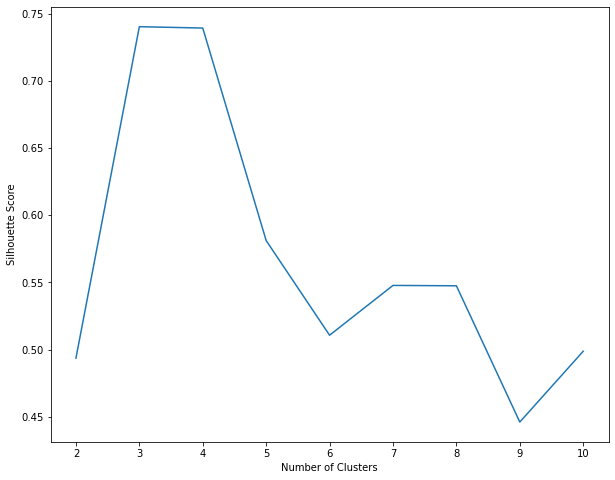

In [16]:
## Add Vector Assembler for silhouette score

from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(inputCols=[
'long',
'lat'],outputCol = 'busy_season_fly_out_of_features')

busy_season_fly_out_of_data = assemble.transform(origin_top_10)
busy_season_fly_out_of_data.show()


# Silhoute Score before CLustering - This takes 10 mins to execute

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='busy_season_fly_out_of_features', \
metricName='silhouette')
for K in range(2,11):

    BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(busy_season_fly_out_of_data)

    BKMeans_transform=BKMeans_fit.transform(busy_season_fly_out_of_data) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')


### BisectingKMeans/Hierarchical Clustering

BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=3) 
BKMeans_Model=BKMeans_.fit(busy_season_fly_out_of_data)
BKMeans_transform=BKMeans_Model.transform(busy_season_fly_out_of_data)
# BKMeans_transform.show()

centroids = BKMeans_Model.clusterCenters()

In [18]:
cluster_0 = BKMeans_transform.filter(BKMeans_transform.prediction==0)
cluster_1 = BKMeans_transform.filter(BKMeans_transform.prediction==1)
cluster_2 = BKMeans_transform.filter(BKMeans_transform.prediction==2)


In [19]:
# ## Add Vector Assembler for silhouette score

# PASS centroids, cluster_K, and the field name with features
from pyspark.ml.linalg import Vectors
import pyspark.sql.functions as F
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row
import numpy as np

##################################################
##################################################
#####
##### Cluster 1
#####
##################################################
##################################################

################################################ FIRST ITERATION
cluster_0_first_iteration = Add_Distance_To_Cluster_DF(centroids,cluster_0,'busy_season_fly_out_of_features', None)
# cluster_0_first_iteration.show()


cluster_0_first_k_Value = get_Highest_Value_cluster_K(cluster_0_first_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_0_first_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_0_first_iteration)
# cluster_first_k_Value_row



################################################ SECOND ITERATION
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_0_first_k_Value
CURRENT_CLUSTER_BEING_PROCESSED = cluster_0
CLUSTER_K_BEING_PROCESSED = None # for 0 its None

cluster_0_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)
# cluster_0_second_iteration.show()

cluster_0_second_k_Value = get_Highest_Value_cluster_K(cluster_0_second_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_0_second_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_0_second_iteration)
#cluster_0_second_k_Value


# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
center_for_third= (abs(cluster_0_first_k_Value[0]-cluster_0_second_k_Value[0]))
temp_val = cluster_0_second_k_Value.copy()
a = center_for_third[0]
b = center_for_third[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
center_for_third = temp_val.copy()
center_for_third   ### <---- This value is used to find the third k


################################################ THIRD ITERATION
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = center_for_third
CURRENT_CLUSTER_BEING_PROCESSED = cluster_0
CLUSTER_K_BEING_PROCESSED = None # for 0 its None

cluster_0_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)
# cluster_0_third_iteration.show()
# CENTER_FEATURE_POINTS_FOR_THIRD_ITERATION = center_for_third
# cluster_0_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_THIRD_ITERATION, cluster_0, 'busy_season_fly_out_of_features')
# cluster_0_third_iteration.show()

cluster_0_third_k_Value = get_Highest_Value_cluster_K(cluster_0_third_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again

cluster_0_third_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_0_third_iteration)
cluster_0_third_k_Value


##################################################
##################################################
#####
##### Cluster 2
#####
##################################################
##################################################

################################### First Iteration
# first iteration has the last param as None always
cluster_1_first_iteration = Add_Distance_To_Cluster_DF(centroids,cluster_1,'busy_season_fly_out_of_features',None)
# cluster_1_first_iteration.show()


cluster_1_first_k_Value = get_Highest_Value_cluster_K(cluster_1_first_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_1_first_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_1_first_iteration)
# cluster_first_k_Value_row

cluster_1_first_k_Value




################################### Second Iteration
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_1_first_k_Value
CURRENT_CLUSTER_BEING_PROCESSED = cluster_1
CLUSTER_K_BEING_PROCESSED = 1 # for 0 its None

cluster_1_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

#cluster_1_second_iteration.show()

# CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_1_first_k_Value
# CURRENT_CLUSTER_BEING_PROCESSED = cluster_1
# cluster_1_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features')
# cluster_1_second_iteration.show()


cluster_1_second_k_Value = get_Highest_Value_cluster_K(cluster_1_second_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_1_second_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_1_second_iteration)
cluster_1_second_k_Value


# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
cluster_1_center_value_for_third= (abs(cluster_1_first_k_Value[0]-cluster_1_second_k_Value[0]))
temp_val = cluster_1_second_k_Value.copy()
a = cluster_1_center_value_for_third[0]
b = cluster_1_center_value_for_third[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
cluster_1_center_value_for_third = temp_val.copy()
cluster_1_center_value_for_third   ### <---- This value is used to find the third k

################################### Third Iteration
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_1_center_value_for_third
CURRENT_CLUSTER_BEING_PROCESSED = cluster_1
CLUSTER_K_BEING_PROCESSED = 1 # for 0 its None

cluster_1_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

#cluster_1_third_iteration.show()
# cluster_1_third_iteration = Add_Distance_To_Cluster_DF(cluster_1_center_value_for_third,cluster_1,'busy_season_fly_out_of_features')
# cluster_1_third_iteration.show()



cluster_1_third_k_Value = get_Highest_Value_cluster_K(cluster_1_third_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again

cluster_1_third_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_1_third_iteration)
cluster_1_third_k_Value



# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
cluster_1_center_value_for_fourth = (abs(cluster_1_first_k_Value[0]-cluster_1_second_k_Value[0]-cluster_1_third_k_Value[0]))
temp_val = cluster_1_second_k_Value.copy()
a = cluster_1_center_value_for_fourth[0]
b = cluster_1_center_value_for_fourth[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
cluster_1_center_value_for_fourth = temp_val.copy()
cluster_1_center_value_for_fourth   ### <---- This value is used to find the third k


##################################################
##################################################
#####
##### Cluster 3
#####
##################################################
##################################################

##################################### FIRST ITERATION

# first iteration has the last param as None always
cluster_2_first_iteration = Add_Distance_To_Cluster_DF(centroids,cluster_2,'busy_season_fly_out_of_features',None)
# cluster_1_first_iteration.show()


cluster_2_first_k_Value = get_Highest_Value_cluster_K(cluster_2_first_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_2_first_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_2_first_iteration)
# cluster_first_k_Value_row

cluster_2_first_k_Value



##################################### SECOND ITERATION

CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_2_first_k_Value
CURRENT_CLUSTER_BEING_PROCESSED = cluster_2
CLUSTER_K_BEING_PROCESSED = 2 # for 0 its None

cluster_2_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

# cluster_2_second_iteration.show()



cluster_2_second_k_Value = get_Highest_Value_cluster_K(cluster_2_second_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_2_second_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_2_second_iteration)
cluster_2_second_k_Value





# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
cluster_2_center_value_for_third= (abs(cluster_2_first_k_Value[0]-cluster_2_second_k_Value[0]))
temp_val = cluster_2_first_k_Value.copy()
a = cluster_2_center_value_for_third[0]
b = cluster_2_center_value_for_third[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
cluster_2_center_value_for_third = temp_val.copy()
cluster_2_center_value_for_third   ### <---- This value is used to find the third k



##################################### THIRD ITERATION

CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_2_center_value_for_third
CURRENT_CLUSTER_BEING_PROCESSED = cluster_2
CLUSTER_K_BEING_PROCESSED = 2 # for 0 its None

cluster_2_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

# cluster_2_third_iteration.show()




cluster_2_third_k_Value = get_Highest_Value_cluster_K(cluster_2_third_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again

cluster_2_third_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_2_third_iteration)
cluster_2_third_k_Value



def move_fraction_closer_to_centroid(passed_cluster_k_value, passed_cluster, a , b):
    temp_a = 0
    temp_b = 0
    if float(passed_cluster_k_value[0][0]) >=  float(passed_cluster[0]):
        temp_a = passed_cluster_k_value[0][0] - a        
    if float(passed_cluster_k_value[0][1]) >=  float(passed_cluster[1]):
        temp_b = passed_cluster_k_value[0][1] - b
    if float(passed_cluster_k_value[0][0]) <  float(passed_cluster[0]):
        temp_a = passed_cluster_k_value[0][0] + a     
    if float(passed_cluster_k_value[0][1]) <  float(passed_cluster[1]):
        temp_b = passed_cluster_k_value[0][1] + a
        
    passed_cluster_k_value = [temp_a, temp_b]
    return passed_cluster_k_value


cluster_0_first_k_Value_temp = cluster_0_first_k_Value.copy()
cluster_0_second_k_Value_temp = cluster_0_second_k_Value.copy()
cluster_0_third_k_Value_temp = cluster_0_third_k_Value.copy()

cluster_centroid = centroids[0]

a = cluster_0_first_k_Value_temp[0][0] * 0.2
b = cluster_0_first_k_Value_temp[0][1] * 0.2

cluster_0_first_k_Value_temp = move_fraction_closer_to_centroid(cluster_0_first_k_Value_temp, cluster_centroid, a, b)
cluster_0_first_k_Value = {}
cluster_0_first_k_Value['features'] = cluster_0_first_k_Value_temp
cluster_0_first_k_Value['prediction'] = 0


a = cluster_0_second_k_Value_temp[0][0] * 0.2
b = cluster_0_second_k_Value_temp[0][1] * 0.2
cluster_0_second_k_Value_temp = move_fraction_closer_to_centroid(cluster_0_second_k_Value_temp, cluster_centroid, a, b)
cluster_0_second_k_Value = {}
cluster_0_second_k_Value['features'] = cluster_0_second_k_Value_temp
cluster_0_second_k_Value['prediction'] = 0


a = cluster_0_third_k_Value_temp[0][0] * 0.2
b = cluster_0_third_k_Value_temp[0][1] * 0.2
cluster_0_third_k_Value_temp = move_fraction_closer_to_centroid(cluster_0_third_k_Value_temp, cluster_centroid, a, b)
cluster_0_third_k_Value = {}
cluster_0_third_k_Value['features'] = cluster_0_third_k_Value_temp
cluster_0_third_k_Value['prediction'] = 0


cluster_1_first_k_Value_temp = cluster_1_first_k_Value.copy()
cluster_1_second_k_Value_temp = cluster_1_second_k_Value.copy()
cluster_1_third_k_Value_temp = cluster_1_third_k_Value.copy()

cluster_centroid = centroids[1]


a = cluster_1_first_k_Value_temp[0][0] * 0.2
b = cluster_1_first_k_Value_temp[0][1] * 0.2
cluster_1_first_k_Value_temp = move_fraction_closer_to_centroid(cluster_1_first_k_Value_temp, cluster_centroid, a, b)
cluster_1_first_k_Value = {}
cluster_1_first_k_Value['features'] = cluster_1_first_k_Value_temp
cluster_1_first_k_Value['prediction'] = 1

a = cluster_1_second_k_Value_temp[0][0] * 0.2
b = cluster_1_second_k_Value_temp[0][1] * 0.2
cluster_1_second_k_Value_temp = move_fraction_closer_to_centroid(cluster_1_second_k_Value_temp, cluster_centroid, a, b)
cluster_1_second_k_Value = {}
cluster_1_second_k_Value['features'] = cluster_1_second_k_Value_temp
cluster_1_second_k_Value['prediction'] = 1

a = cluster_1_third_k_Value_temp[0][0] * 0.2
b = cluster_1_third_k_Value_temp[0][1] * 0.2
cluster_1_third_k_Value_temp = move_fraction_closer_to_centroid(cluster_1_third_k_Value_temp, cluster_centroid, a, b)
cluster_1_third_k_Value = {}
cluster_1_third_k_Value['features'] = cluster_1_third_k_Value_temp
cluster_1_third_k_Value['prediction'] = 1



cluster_2_first_k_Value_temp = cluster_2_first_k_Value.copy()
cluster_2_second_k_Value_temp = cluster_2_second_k_Value.copy()
cluster_2_third_k_Value_temp = cluster_2_third_k_Value.copy()

cluster_centroid = centroids[2]


a = cluster_2_first_k_Value_temp[0][0] * 0.2
b = cluster_2_first_k_Value_temp[0][1] * 0.2
cluster_2_first_k_Value_temp = move_fraction_closer_to_centroid(cluster_2_first_k_Value_temp, cluster_centroid, a, b)
cluster_2_first_k_Value = {}
cluster_2_first_k_Value['features'] = cluster_2_first_k_Value_temp
cluster_2_first_k_Value['prediction'] = 2

a = cluster_2_second_k_Value_temp[0][0] * 0.2
b = cluster_2_second_k_Value_temp[0][1] * 0.2
cluster_2_second_k_Value_temp = move_fraction_closer_to_centroid(cluster_2_second_k_Value_temp, cluster_centroid, a, b)
cluster_2_second_k_Value = {}
cluster_2_second_k_Value['features'] = cluster_2_second_k_Value_temp
cluster_2_second_k_Value['prediction'] = 2

a = cluster_2_third_k_Value_temp[0][0] * 0.2
b = cluster_2_third_k_Value_temp[0][1] * 0.2
cluster_2_third_k_Value_temp = move_fraction_closer_to_centroid(cluster_2_third_k_Value_temp, cluster_centroid, a, b)
cluster_2_third_k_Value = {}
cluster_2_third_k_Value['features'] = cluster_2_third_k_Value_temp
cluster_2_third_k_Value['prediction'] = 2


comparison = [cluster_0_first_k_Value,
cluster_0_second_k_Value,
cluster_0_third_k_Value,
cluster_1_first_k_Value,
cluster_1_second_k_Value,
cluster_1_third_k_Value,
cluster_2_first_k_Value,
cluster_2_second_k_Value,
cluster_2_third_k_Value]


for i in comparison:
    print(i)



{'features': [-177.43160328, 51.850941999999996], 'prediction': 0}
{'features': [-97.84745047999999, 37.959185552], 'prediction': 0}
{'features': [-198.53429496, 51.609761776000006], 'prediction': 0}
{'features': [-59.85077466400001, 32.221352888], 'prediction': 1}
{'features': [-65.571596888, 16.977055777999997], 'prediction': 1}
{'features': [-103.58216900400001, 33.367162888], 'prediction': 1}
{'features': [121.65400079999999, 11.2626664], 'prediction': 2}
{'features': [116.4971072, 11.9968888], 'prediction': 2}
{'features': [110.47999999999999, 37.136700000000005], 'prediction': 2}


## PASS 2 OF CURE ALGORITHM
### RESCAN WHOLE DATASET AND COMPARE EACH POINT WITH REPRESENTATIVE POINTS
### CLOSEST POINT CAN BE TAGGED AS CLUSTER K

In [ ]:

## FOR EACH DATA POINT do this:
### given the lat and long - use those x and y in squared distance with each x and y from comparison variable
# calculate the distance for each value in comparison
# then select the smallest distance
# add prediction of that smallest to column prediction


In [14]:
# # simply counting records for origin airport (doesnt matter if these flights were cancelled or not, its about intent)

# # need to read in metadata for airport names
# airport_metadata = spark.read.options(inferSchema=True,header=True).csv('airplane_raw/metadata/airports.csv')
# iata_airport_pairs = airport_metadata.select('iata', 'airport','lat', 'long')
# pass_2_data_origin_top_10 = raw.select('Origin','Month').withColumnRenamed('Origin','iata').join(iata_airport_pairs,'iata','inner')
# # origin_top_10 = raw.select('Origin','Month','Year').where(raw.Year == 1999).withColumnRenamed('Origin','iata')\
# #                                     .groupBy('iata','Month','Year')\
# #                                     .count()\
# #                                     .join(iata_airport_pairs,'iata','inner')\
# #                                     .orderBy('count',ascending=False)
# pass_2_data_origin_top_10.show(20)
# #pass_2_data_origin_top_10.count()


# # lat|long|closest_distance|prediction

+----+-----+--------------------+-----------+------------+
|iata|Month|             airport|        lat|        long|
+----+-----+--------------------+-----------+------------+
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.1063105

In [20]:
# simply counting records for origin airport (doesnt matter if these flights were cancelled or not, its about intent)

# need to read in metadata for airport names
airport_metadata = spark.read.options(inferSchema=True,header=True).csv('airplane_raw/metadata/airports.csv')
iata_airport_pairs = airport_metadata.select('iata', 'airport','lat', 'long')

pass_2_data_origin_top_10 = raw.select('Origin','Month', 'DepDelay').withColumnRenamed('Origin','iata').groupBy('iata','Month').count().orderBy('count',ascending=False).join(iata_airport_pairs,'iata','inner')
df_only_month_depdelay = raw.select('Origin','Month','DepDelay').withColumnRenamed('Origin','iata').groupBy('iata','Month').agg(F.sum('DepDelay').alias("total_DepDelay"))

pass_2_data_origin_top_10 = pass_2_data_origin_top_10.join(df_only_month_depdelay, ["Month", 'iata']).orderBy('count',ascending=False)


pass_2_data_origin_top_10.show(20)



# lat|long|closest_distance|prediction

+-----+----+------+--------------------+-----------+------------+--------------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|
+-----+----+------+--------------------+-----------+------------+--------------+
|   10| ORD|338240|Chicago O'Hare In...|  41.979595|-87.90446417|     2450126.0|
|   12| ORD|329205|Chicago O'Hare In...|  41.979595|-87.90446417|     4267514.0|
|   11| ORD|318565|Chicago O'Hare In...|  41.979595|-87.90446417|     2679858.0|
|    8| ORD|318116|Chicago O'Hare In...|  41.979595|-87.90446417|     3612593.0|
|    7| ORD|315239|Chicago O'Hare In...|  41.979595|-87.90446417|     3775236.0|
|    3| ORD|313278|Chicago O'Hare In...|  41.979595|-87.90446417|     3230570.0|
|    5| ORD|312322|Chicago O'Hare In...|  41.979595|-87.90446417|     2945484.0|
|    1| ORD|307081|Chicago O'Hare In...|  41.979595|-87.90446417|     3852912.0|
|    6| ORD|306550|Chicago O'Hare In...|  41.979595|-87.90446417|     3850659.0|
|    4| ORD|303434|Chicago O

In [21]:
assemble = VectorAssembler(inputCols=[
'long',
'lat'],outputCol = 'features')

pass_2_data_features = assemble.transform(pass_2_data_origin_top_10)
pass_2_data_features.show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+
|   10| ORD|338240|Chicago O'Hare In...|  41.979595|-87.90446417|     2450126.0|[-87.90446417,41....|
|   12| ORD|329205|Chicago O'Hare In...|  41.979595|-87.90446417|     4267514.0|[-87.90446417,41....|
|   11| ORD|318565|Chicago O'Hare In...|  41.979595|-87.90446417|     2679858.0|[-87.90446417,41....|
|    8| ORD|318116|Chicago O'Hare In...|  41.979595|-87.90446417|     3612593.0|[-87.90446417,41....|
|    7| ORD|315239|Chicago O'Hare In...|  41.979595|-87.90446417|     3775236.0|[-87.90446417,41....|
|    3| ORD|313278|Chicago O'Hare In...|  41.979595|-87.90446417|     3230570.0|[-87.90446417,41....|
|    5| ORD|312322|Chicago O'Hare In...|  41.979595|-87.90446417|     2945484.0|[-

In [59]:
# import math
# x = [-76.10631056,43.11118694]
# ggg = None
# for i in comparison:
#     # temp = float(x.squared_distance(i['features']))
#     temp = int( math.sqrt( (i['features'][0] - x[0])**2 + ((i['features'][1] - x[1])**2  ) ))
#     print(' ')
#     print('value: ' + str(temp))
#     if ggg == None:
#         ggg = temp
#         prediction = i['prediction']
#     elif temp < ggg:
#         ggg = temp
#         prediction = i['prediction']
#     print("dist " + str(ggg))
#     print("temp " + str(temp))
# print(ggg)

In [22]:
import math

def check_distance(x):
    dist = None
    prediction = None
    for i in comparison:
        temp = float(x.squared_distance(i['features']))
        #temp = int( math.sqrt( (i['features'][0] - x[0])**2 + ((i['features'][1] - x[1])**2  ) ))
        if dist == None:
            dist = temp
            prediction = i['prediction']
        elif temp < dist:
            dist = temp
            prediction = i['prediction']
    return prediction

calc_smallest_distance = F.udf(lambda features : check_distance(features))
pass_2_data_features = pass_2_data_features.withColumn('prediction',calc_smallest_distance('features'))
pass_2_data_features.show()


+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   10| ORD|338240|Chicago O'Hare In...|  41.979595|-87.90446417|     2450126.0|[-87.90446417,41....|         0|
|   12| ORD|329205|Chicago O'Hare In...|  41.979595|-87.90446417|     4267514.0|[-87.90446417,41....|         0|
|   11| ORD|318565|Chicago O'Hare In...|  41.979595|-87.90446417|     2679858.0|[-87.90446417,41....|         0|
|    8| ORD|318116|Chicago O'Hare In...|  41.979595|-87.90446417|     3612593.0|[-87.90446417,41....|         0|
|    7| ORD|315239|Chicago O'Hare In...|  41.979595|-87.90446417|     3775236.0|[-87.90446417,41....|         0|
|    3| ORD|313278|Chicago O'Hare In...|  41.979595|-87.90446417|     3230570.0|[-87.90446417,41

## Cluster 0 with highest count

In [12]:
# aaaa = pass_2_data_features.groupBy('iata','Month','prediction')\
#                                     .count()\
#                                     .orderBy('count',ascending=False)
# aaaa.show()

In [23]:
cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
cluster2_dataframe.sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   10| ORD|338240|Chicago O'Hare In...|  41.979595|-87.90446417|     2450126.0|[-87.90446417,41....|         0|
|   12| ORD|329205|Chicago O'Hare In...|  41.979595|-87.90446417|     4267514.0|[-87.90446417,41....|         0|
|   11| ORD|318565|Chicago O'Hare In...|  41.979595|-87.90446417|     2679858.0|[-87.90446417,41....|         0|
|    8| ORD|318116|Chicago O'Hare In...|  41.979595|-87.90446417|     3612593.0|[-87.90446417,41....|         0|
|    7| ORD|315239|Chicago O'Hare In...|  41.979595|-87.90446417|     3775236.0|[-87.90446417,41....|         0|
|    3| ORD|313278|Chicago O'Hare In...|  41.979595|-87.90446417|     3230570.0|[-87.90446417,41

In [27]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

from pyspark.sql import Window
w = Window.partitionBy('iata')
cluster2_dataframe.withColumn('countB', f.max('count').over(w))\
    .where(f.col('count') == f.col('countB'))\
    .drop('countB').filter(pass_2_data_features.prediction==0).sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   10| ORD|338240|Chicago O'Hare In...|  41.979595|-87.90446417|     2450126.0|[-87.90446417,41....|         0|
|   10| DFW|293925|Dallas-Fort Worth...|32.89595056|    -97.0372|     2246265.0|[-97.0372,32.8959...|         0|
|   10| ATL|291740|William B Hartsfi...|33.64044444|-84.42694444|     1921669.0|[-84.42694444,33....|         0|
|   10| STL|181351|Lambert-St Louis ...|38.74768694|-90.35998972|     1121845.0|[-90.35998972,38....|         0|
|   10| DTW|162109|Detroit Metropoli...|42.21205889|-83.34883583|      930185.0|[-83.34883583,42....|         0|
|   10| MSP|146583|Minneapolis-St Pa...|44.88054694| -93.2169225|      698424.0|[-93.2169225,44.

## Highest delay in cluster 0

In [28]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

cluster2_dataframe.orderBy('total_DepDelay',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   12| ORD|329205|Chicago O'Hare In...|  41.979595|-87.90446417|     4267514.0|[-87.90446417,41....|         0|
|    1| ORD|307081|Chicago O'Hare In...|  41.979595|-87.90446417|     3852912.0|[-87.90446417,41....|         0|
|    6| ORD|306550|Chicago O'Hare In...|  41.979595|-87.90446417|     3850659.0|[-87.90446417,41....|         0|
|    7| ORD|315239|Chicago O'Hare In...|  41.979595|-87.90446417|     3775236.0|[-87.90446417,41....|         0|
|   12| DFW|288188|Dallas-Fort Worth...|32.89595056|    -97.0372|     3702858.0|[-97.0372,32.8959...|         0|
|    8| ORD|318116|Chicago O'Hare In...|  41.979595|-87.90446417|     3612593.0|[-87.90446417,41

## Cluster 1 with highest count

In [14]:
 # aaaa.filter(aaaa.prediction==1).show()

In [30]:
cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==1)
cluster2_dataframe.sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   10| LAX|210095|Los Angeles Inter...|33.94253611|-118.4080744|     1693407.0|[-118.4080744,33....|         1|
|   12| LAX|205143|Los Angeles Inter...|33.94253611|-118.4080744|     2469082.0|[-118.4080744,33....|         1|
|    8| LAX|198749|Los Angeles Inter...|33.94253611|-118.4080744|     1784381.0|[-118.4080744,33....|         1|
|   11| LAX|198666|Los Angeles Inter...|33.94253611|-118.4080744|     1761967.0|[-118.4080744,33....|         1|
|    7| LAX|197134|Los Angeles Inter...|33.94253611|-118.4080744|     1547965.0|[-118.4080744,33....|         1|
|    5| LAX|190317|Los Angeles Inter...|33.94253611|-118.4080744|     1275191.0|[-118.4080744,33

In [31]:
from pyspark.sql import Window
w = Window.partitionBy('iata')
cluster2_dataframe.withColumn('countB', f.max('count').over(w))\
    .where(f.col('count') == f.col('countB'))\
    .drop('countB').filter(pass_2_data_features.prediction==1).sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   10| LAX|210095|Los Angeles Inter...|33.94253611|-118.4080744|     1693407.0|[-118.4080744,33....|         1|
|   12| PHX|177728|Phoenix Sky Harbo...|33.43416667|-112.0080556|     2168837.0|[-112.0080556,33....|         1|
|   10| DEN|168423|         Denver Intl|39.85840806|-104.6670019|     1082648.0|[-104.6670019,39....|         1|
|   10| SFO|157007|San Francisco Int...|37.61900194|-122.3748433|     1450528.0|[-122.3748433,37....|         1|
|   10| EWR|141698|         Newark Intl|40.69249722|-74.16866056|      950431.0|[-74.16866056,40....|         1|
|   10| LAS|122783|McCarran Internat...|36.08036111|-115.1523333|      982087.0|[-115.1523333,36

## Highest delay in Cluster 1

In [32]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

cluster2_dataframe.orderBy('total_DepDelay',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   12| LAX|205143|Los Angeles Inter...|33.94253611|-118.4080744|     2469082.0|[-118.4080744,33....|         1|
|   12| DEN|165593|         Denver Intl|39.85840806|-104.6670019|     2339611.0|[-104.6670019,39....|         1|
|   12| PHX|177728|Phoenix Sky Harbo...|33.43416667|-112.0080556|     2168837.0|[-112.0080556,33....|         1|
|   12| SFO|150802|San Francisco Int...|37.61900194|-122.3748433|     2026548.0|[-122.3748433,37....|         1|
|    1| LAX|187176|Los Angeles Inter...|33.94253611|-118.4080744|     1893706.0|[-118.4080744,33....|         1|
|    8| LAX|198749|Los Angeles Inter...|33.94253611|-118.4080744|     1784381.0|[-118.4080744,33

## Cluster 2 with highest count

In [16]:
 # aaaa.filter(aaaa.prediction==2).show()

In [34]:
cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==2)
cluster2_dataframe.sort('count',ascending=False).show()

+-----+----+-----+--------------------+---------+----------+--------------+--------------------+----------+
|Month|iata|count|             airport|      lat|      long|total_DepDelay|            features|prediction|
+-----+----+-----+--------------------+---------+----------+--------------+--------------------+----------+
|    3| SPN|  950|Tinian Internatio...|14.996111|145.621384|         -43.0|[145.621384,14.99...|         2|
|    1| SPN|  948|Tinian Internatio...|14.996111|145.621384|        2366.0|[145.621384,14.99...|         2|
|   12| SPN|  945|Tinian Internatio...|14.996111|145.621384|        2962.0|[145.621384,14.99...|         2|
|    4| SPN|  919|Tinian Internatio...|14.996111|145.621384|        -528.0|[145.621384,14.99...|         2|
|   10| SPN|  909|Tinian Internatio...|14.996111|145.621384|        -851.0|[145.621384,14.99...|         2|
|    2| SPN|  885|Tinian Internatio...|14.996111|145.621384|        2563.0|[145.621384,14.99...|         2|
|   11| SPN|  879|Tinian Int

In [35]:
from pyspark.sql import Window
w = Window.partitionBy('iata')
cluster2_dataframe.withColumn('countB', f.max('count').over(w))\
    .where(f.col('count') == f.col('countB'))\
    .drop('countB').filter(pass_2_data_features.prediction==2).sort('count',ascending=False).show()

+-----+----+-----+--------------------+---------+----------+--------------+--------------------+----------+
|Month|iata|count|             airport|      lat|      long|total_DepDelay|            features|prediction|
+-----+----+-----+--------------------+---------+----------+--------------+--------------------+----------+
|    3| SPN|  950|Tinian Internatio...|14.996111|145.621384|         -43.0|[145.621384,14.99...|         2|
|    1| ROR|  214|    Babelthoup/Koror| 7.367222|134.544167|        1532.0|[134.544167,7.367...|         2|
|   10| ROP|  201|         Prachinburi|14.078333|101.378334|       -1186.0|[101.378334,14.07...|         2|
|    5| YAP|   72|   Yap International|   9.5167|     138.1|         606.0|      [138.1,9.5167]|         2|
+-----+----+-----+--------------------+---------+----------+--------------+--------------------+----------+



## Highest delay in cluster 2

In [19]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

cluster2_dataframe.orderBy('total_DepDelay',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   12| ORD|534155|Chicago O'Hare In...|  41.979595|-87.90446417|     7926294.0|[-87.90446417,41....|         2|
|    1| ORD|546669|Chicago O'Hare In...|  41.979595|-87.90446417|     7620616.0|[-87.90446417,41....|         2|
|    7| ORD|531262|Chicago O'Hare In...|  41.979595|-87.90446417|     7010633.0|[-87.90446417,41....|         2|
|    6| ORD|516619|Chicago O'Hare In...|  41.979595|-87.90446417|     6866518.0|[-87.90446417,41....|         2|
|    3| ORD|556663|Chicago O'Hare In...|  41.979595|-87.90446417|     6812098.0|[-87.90446417,41....|         2|
|    8| ORD|536420|Chicago O'Hare In...|  41.979595|-87.90446417|     6514646.0|[-87.90446417,41

### Plot the clusters

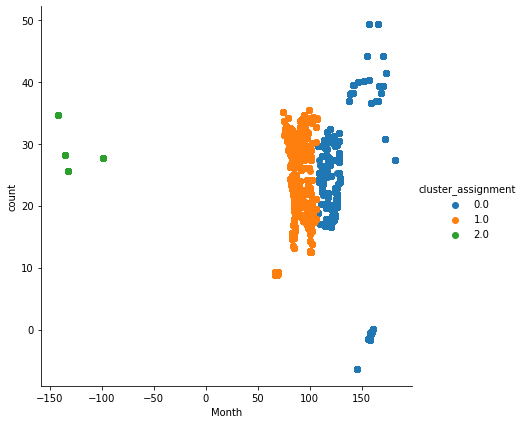

In [12]:
from pyspark.ml.feature import PCA as PCAml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pca1 = PCAml(k=2, inputCol="busy_season_fly_out_of_features", outputCol="pca")
# pca_model = pca.fit(busy_season_fly_out_of_data)
pca_model1 = pca1.fit(BKMeans_transform)

pca_transformed1 = pca_model1.transform(busy_season_fly_out_of_data)


# BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=3) 
# BKMeans_Model=BKMeans_.fit(busy_season_fly_out_of_data)
# BKMeans_transform=BKMeans_Model.transform(busy_season_fly_out_of_data)
# # BKMeans_transform.show()

# extracting the principal components
X_pca1 = pca_transformed1.rdd.map(lambda row: row.pca).collect()
X_pca1 = np.array(X_pca1)

# Retrieve cluster assigned from the above clustering
cluster_assignment1 = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)


# Plotting the data
pca_data1 = np.hstack((X_pca1,cluster_assignment1))

pca_df = pd.DataFrame(data=pca_data1, columns=("Month", "count","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, "Month", "count").add_legend()
plt.show()